In [1]:
%matplotlib inline
%run ./lorenz_system.py
import math

In [2]:
stepCnt = 1000

In [3]:
xs,ys,zs = build_system(stepCnt)

# Lorenz System

$$
\dfrac{dx}{dt} = \sigma(y-x)
$$
$$
\dfrac{dy}{dt} = x(\rho -z) - y 
$$
$$
\dfrac{dz}{dt} = xy-\beta z
$$

# Baseline Plots

## 3d Plot

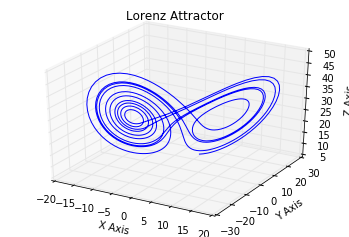

In [4]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

## 2d Plots

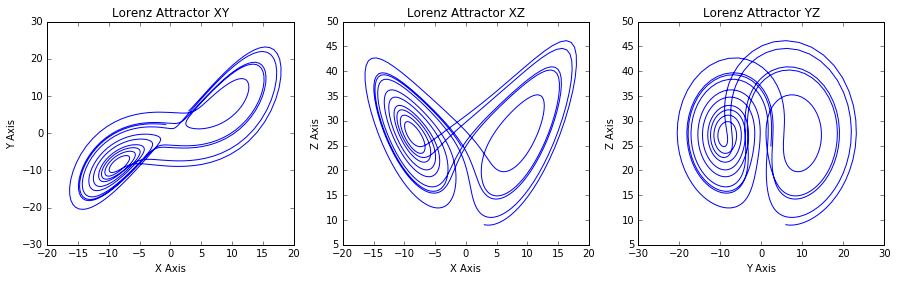

In [5]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_figwidth(15)
ax1.plot(xs, ys)
ax1.set_xlabel("X Axis")
ax1.set_ylabel("Y Axis")
ax1.set_title("Lorenz Attractor XY")

ax2.plot(xs, zs)
ax2.set_xlabel("X Axis")
ax2.set_ylabel("Z Axis")
ax2.set_title("Lorenz Attractor XZ")

ax3.plot(ys, zs)
ax3.set_xlabel("Y Axis")
ax3.set_ylabel("Z Axis")
ax3.set_title("Lorenz Attractor YZ")

# Wind Direction

In [6]:
def get_wind_angle(p1, p2):
    ''' 
    return slope between the two points
    '''
    # get slope
    slope = (p2[len(p2) - 1] - p2[0]) / (p1[len(p1) - 1] - p1[0])

    # get direction of line
    # 1  = up
    # -1 = down
    direction = 1 
    
    if p2[0] < p2[len(p2) - 1]:
        direction = -1
    elif p2[0] > p2[len(p2) - 1]:
        direction = 1
    else:
        direction = 0
    
    # initialize theta
    theta = 0
    
    if direction == 0:
        # this is a straight line
        theta = 0 if p1[0] < p1[len(p1) - 1] else 180
    elif p2[len(p2) - 1] == p2[0]:
        theta = 90 if direction == 1 else 270
    else:
        # get angle in  degrees, atan(y / x)
        theta = math.degrees(math.atan2(slope, 1))

        # get angle relative to whole graph
        if theta < 0 and direction == 1:
            theta = (theta * -1) + 90
        elif theta < 0 and direction == -1:
            theta = (theta * -1) + 180
        elif theta >= 0 and direction == -1:
            theta += 270
    
    return math.radians(theta)

In [7]:
def build_wind_angles(coords_a, coords_b, iterator = 10):
    '''
    build list of wind angles
    
    Paramters:
        coords_a - part a of coordinate linking up with coords_b
        coords_b - part b of coordiante linking up with coords a
    '''
    a      = []
    b      = []
    angles = []

    for minimum in range(0, len(coords_a) - iterator, iterator):
        maximum = minimum + iterator

        # store info
        a.append(ys[minimum])
        b.append(zs[minimum])
        angles.append(get_wind_angle(coords_a[minimum:maximum], coords_b[minimum:maximum]))
    
    return a, b, angles

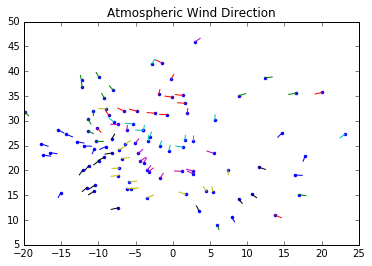

In [8]:
x,y,angles = build_wind_angles(ys,zs)

line = plt.figure()

plt.plot(x, y, ".")

for i in range(len(angles)):
    angle = angles[i]
    x_cor = x[i]
    y_cor = y[i]
    
    plt.plot([x_cor, x_cor + math.cos(angle)], [y_cor, y_cor + math.sin(angle)])

plt.title("Atmospheric Wind Direction")

# Lorenz Attractor Centers

## Derivation

$$
Q = (\pm \sqrt{b(r-1)}, \pm \sqrt{b(r-1)}, r-1 )
$$

In [9]:
def get_yz_centers(b,r,one=False):
    x = math.sqrt(const_b*(const_r - 1))
    y = math.sqrt(const_b*(const_r - 1))
    z = r - 1
    
    if one:
        return y,z
    else:
        return (y,-y), (z,z)

## Two Centers

In [10]:
y_center, z_center = get_yz_centers(const_b, const_r)

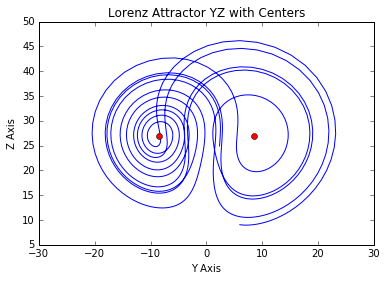

In [11]:
fig = plt.figure()
ax = fig.gca()

ax.plot(ys, zs)
ax.plot(y_center,z_center,'ro')
ax.set_xlabel("Y Axis")
ax.set_ylabel("Z Axis")
ax.set_title("Lorenz Attractor YZ with Centers")

plt.show()

## One Center

In [12]:
one_x,one_y,one_z = build_system(stepCnt,s=2)


y_center, z_center = get_yz_centers(const_b, const_r, one=True)

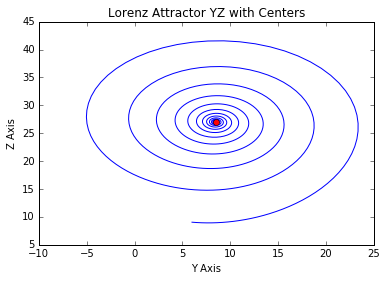

In [13]:
fig = plt.figure()
ax = fig.gca()

ax.plot(one_y, one_z)
ax.plot(y_center,z_center,'ro')
ax.set_xlabel("Y Axis")
ax.set_ylabel("Z Axis")
ax.set_title("Lorenz Attractor YZ with Centers")

plt.show()

## Results

One center requires use of positive y and z.

Two centers requires use of both positive and negative y and positive z to match both.

# Pressure

In [14]:
sea_level_pressure_max = 1085
sea_level_pressure_min = 870

$$
dist = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}
$$

In [15]:
def dist(p1, p2):
    '''
    return distance between two coordinates
    
    Parameters:
        p1 - xy coordinates
        p2 - xy coordinates
        
    Return:
        float - distnace between p1 and p2
    '''
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

In [16]:
def cluster_low_hi_points(x_axis, y_axis, center_one, center_two):
    '''
    DESCRIPTION_HERE
    
    Parameters:
        x_axis     - array containing coordinate adjace to y_axis
        y_axis     - array containing coordinate adjace to x_axis
        center_one - coordiantes for Lorenz Attractor one
        center_two - coordinates for Lorenz Attractor two
    
    Return:
        attractor_one_points - array for Lorenz Attractor one with
                               a calculated distnace
        attractor_two_points - array for Lorenz Attractor two with
                               a calculated distance
    '''
    attractor_one_points  = []
    attractor_two_points = []
    
    for i in range(len(x_axis)):
        point = (x_axis[i], y_axis[i])
        cent_one_dist = dist(point, center_one)
        cent_two_dist = dist(point, center_two)
        
        if cent_one_dist < cent_two_dist:
            point = {
                'coord': point,
                'dist': cent_one_dist
            }
            attractor_one_points.append(point)
        else:
            point = {
                'coord': point,
                'dist': cent_two_dist
            }
            attractor_two_points.append(point)
    
    return attractor_one_points, attractor_two_points

Standard Deviation Formula:
$$
\sigma = \sqrt{\dfrac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2}
$$

In [17]:
def compute_attractor_distance_standard_deviation(attractor):
    '''
    compute the standard deviation of the distance of the points to 
    the attractor
    
    Paramaters:
        attractor - one of the return results computed in funciton 
                    cluster_low_hi_points
                    
    Return:
        float - standard deviation
    '''
    # calculate the mean
    mean = 0
    for i in range(len(attractor)):
        mean += attractor[i]['dist']
    mean /= len(attractor)
    
    # Perform summation
    summation = 0
    for i in range(len(attractor)):
        summation += (attractor[i]['dist'] - mean)**2
        
    # divide summation by N
    summation /= len(attractor)
    
    # return square root
    return math.sqrt(summation)

$$
\sigma x = dist \\
x = \dfrac{dist}{\sigma}
$$

In [18]:
def cluster_attractor_groups(attractor, attractor_std):
    '''
    cluster points together by standard deviation using above formula
    to calculate the index for the array
    
    Parameters:
        attractor        - array of points attracted
        attractor_std    - standard devation of points attracted
        
    Return:
        attractor_groups - matrix with groups by index of closest to furthest
    '''
    attractor_groups = []
    
    for point in attractor:
        std_index = int(point['dist'] / attractor_std)

        # check if array needs to be extended
        if len(attractor_groups) - 1 < std_index:
            attractor_groups.extend([[] for i in range(std_index + 1 - len(attractor_groups))])

        # add point to array
        attractor_groups[std_index].append(point)
    
    return attractor_groups

In [19]:
def format_attractor_groups_plot(attractor):
    '''
    turn an attactor group into a plottable format
    
    Parameters:
        attractor - attractor group created in cluster_attractor_groups
        
    Return:
        x         - array of x points to plot
        y         - array of y points to plot
    '''
    x = []
    y = []
    
    for i in range(len(attractor)):
        x.append([])
        y.append([])
        
        for j in range(len(attractor[i])):
            x[i].append(attractor[i][j]['coord'][0])
            y[i].append(attractor[i][j]['coord'][1])
    
    return x,y

## Two Center

In [34]:
xs,ys,zs = build_system(stepCnt)
y_center, z_center = get_yz_centers(const_b, const_r)

In [35]:
attractor_one, attractor_two = cluster_low_hi_points(x,y,(y_center[0], z_center[0]),(y_center[1],z_center[1]))

In [36]:
attractor_one_std = compute_attractor_distance_standard_deviation(attractor_one)
attractor_two_std = compute_attractor_distance_standard_deviation(attractor_two)

In [54]:
attractor_one_groups = cluster_attractor_groups(attractor_one, 4)
attractor_two_groups = cluster_attractor_groups(attractor_two, 4)

In [55]:
a_one_x, a_one_y = format_attractor_groups_plot(attractor_one_groups)
a_two_x, a_two_y = format_attractor_groups_plot(attractor_two_groups)

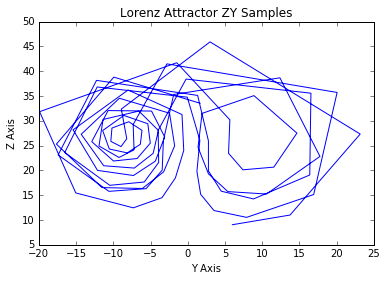

In [56]:
fig = plt.figure()
ax = fig.gca()
ax.plot(x, y)
ax.set_xlabel("Y Axis")
ax.set_ylabel("Z Axis")
ax.set_title("Lorenz Attractor ZY Samples")

plt.show()

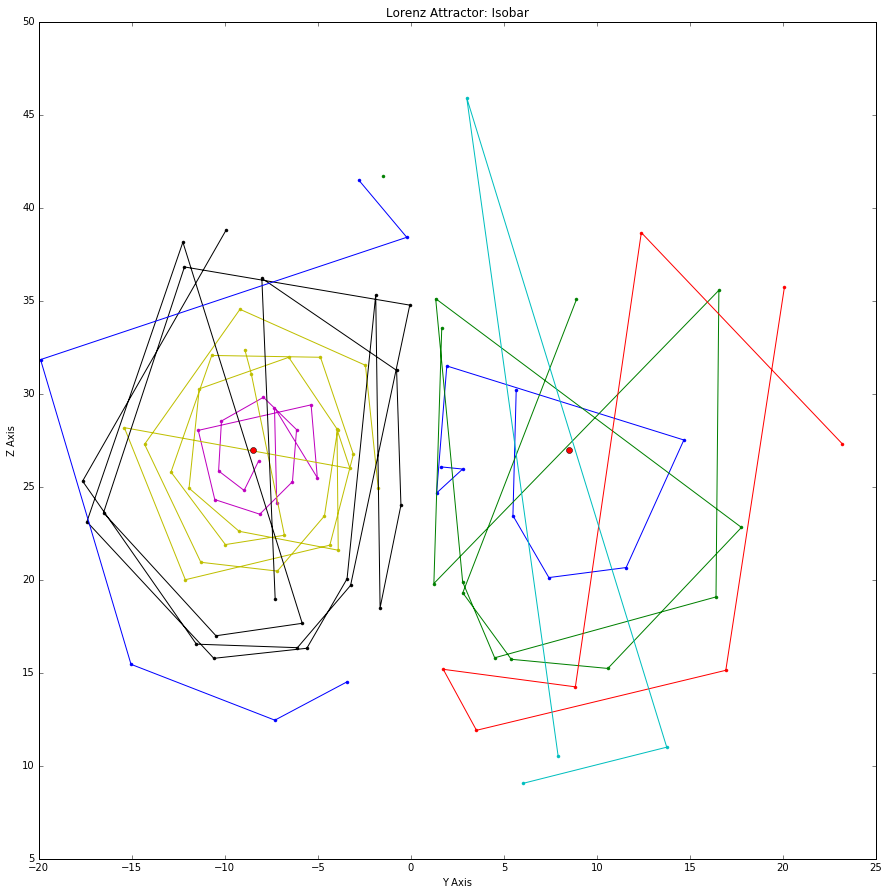

In [57]:
fig = plt.figure()
ax = fig.gca()
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(len(a_one_x)):
    if len(a_one_x[i]) > 0:
        ax.plot(a_one_x[i], a_one_y[i],'.-')
        
for i in range(len(a_two_x)):
    if len(a_two_x[i]) > 0:
        ax.plot(a_two_x[i], a_two_y[i],'.-')

ax.plot(y_center,z_center,'ro')
# ax.plot(ys, zs)

ax.set_xlabel("Y Axis")
ax.set_ylabel("Z Axis")
ax.set_title("Lorenz Attractor: Isobar")

plt.show()

## Two Centers